# Chapter 4 Training Models

This chapter goes over the details of how certain model parameters are calculated, in particular using closed form equations and the different types of gradient descent. It covers linear regression, polynomial regression, logistic regression, and softmax regression, as well as concepts such as regularization and and learning curves. 

## Linear Regression

### Closed form solution

One way of training a linear regression model, or finding the parameters that minimize some cost function (residual sum of squares, in this case), is to use an explicit formula, which can be seen [here](https://en.wikipedia.org/wiki/Ordinary_least_squares#Estimation). This is what sklearn's LinearRegression model is doing under the hood. Let's do it both explicitly and then using sklearn's modules.

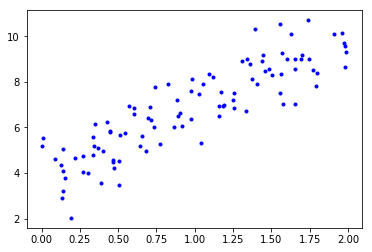

In [34]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Generate linear data with some noise and plot
# y = 4 + 3x
X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)
plt.plot(X, y, 'b.');

In [35]:
# Add feature with value of 1 to X to represent intercept term
X_b = np.c_[np.ones((X.shape[0], 1)), X]
# Calculate parameters using psuedo-inverse (closed-form solution)
theta_best = np.linalg.pinv(X_b).dot(y)

In [36]:
# Compare estimated values to known values of 4 and 3
theta_best

array([[3.92169369],
       [2.9987567 ]])

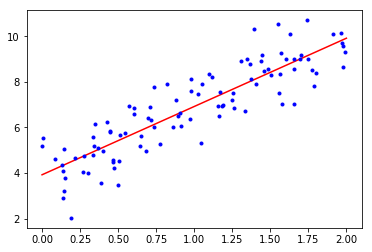

In [37]:
# Plot line generated by parameters

# Define x values for line
X_limits = np.array([[0], [2]])
# Add intercept term to calculate y values
X_limits_with_intercept = np.c_[np.ones((2, 1)), X_limits]
y_predict = X_limits_with_intercept.dot(theta_best)

plt.plot(X_limits, y_predict, "r-");
plt.plot(X, y, "b.");

In [38]:
from sklearn.linear_model import LinearRegression

# Use sklearn's linear regression modelkkkk
lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([3.92169369]), array([[2.9987567]]))

We can see that the estimated parameters are the same in both cases. 

### Gradient Descent

However, this computation does not work well when we have a large number of features. For that, we turn to gradient descent. Again, we try to minimize a cost function, but this time by initializing our parameters with random values and updating them based on the gradient of the cost function until we reach a minima (not necessarily global). In particular, we calculate the gradient, multiply it by our learning rate, and subtract this vector from the current parameter vector. Again, let's implement this algorithm ourselves explicitly.

In [39]:
eta = 0.1 # Learning rate
n_iters = 1000
m = X.shape[0] # Number of data points

# Initialize random values
theta = np.random.rand(2,1)

for iteration in np.arange(n_iters):
    gradient = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradient
    
theta

array([[3.92169369],
       [2.9987567 ]])

There are two hyperparameters to consider here: our learning rate and the number of iterations. A high learning rate can easily miss the minimum, and a low learning rate will converge slowly, visualized below.

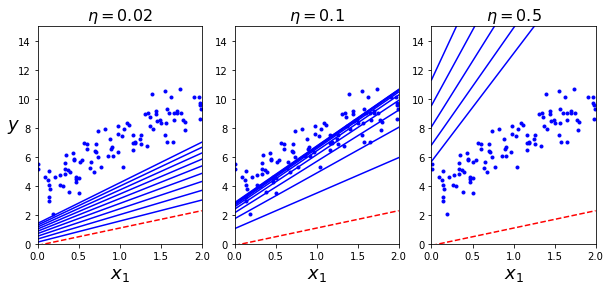

In [41]:
theta_path_bgd = []

def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_iterations = 1000
    for iteration in range(n_iterations):
        if iteration < 10:
            y_predict = X_limits_with_intercept.dot(theta)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(X_limits, y_predict, style)
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients
        if theta_path is not None:
            theta_path.append(theta)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title(r"$\eta = {}$".format(eta), fontsize=16)
    
theta = np.random.randn(2,1)  # random initialization

plt.figure(figsize=(10,4))
plt.subplot(131); plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132); plot_gradient_descent(theta, eta=0.1, theta_path=theta_path_bgd)
plt.subplot(133); plot_gradient_descent(theta, eta=0.5)

The graph on the left has a low learning rate, and we can see that while the parameters get closer to the optimal solution, they are doing so quite slowly. The graph on the right has a high learning rate, and so the lines that are generated are changing too drastically to settle on the best solution. The graph in the middle shows a good learning rate. A good learning rate can be found with grid search.

We must also decide upon the number of iterations. If we don't iterate enough, we won't get close enough to the solution (for example, imagine we settled upon the best line in the graph on the left.) On the other hand, too many iterations will waste computing resources if we're already close enough to our optimal solution. We can deal with this by stopping our algorithm once our gradient vector becomes small enough, since we then know that further changes will be small as well.

### Stochastic Gradient Descent

If our training set is large, gradient descent will be slow because it calculates the gradient using every data point in each iteration. An alternative approach is stochastic gradient descent, which uses only one instance to calculate the gradient and update our parameters. This obviously performs much faster, but converges much more irregularly since a single instance can have an unusually drastic effect on the gradient, while gradient descent smooths out possible irregularities by looking at the whole data set at once. However, this can also help us find a global minimum if a particular data point has a large enough effect to take us out of a local minimum. 

One way to deal with this randomness is to gradually reduce the learning rate, so that subsequent points have a smaller effect when we update our parameters. The function that determines how the learning rate is reduced is called the learning schedule. Again, reducing this rate too quickly may force you to converge on a suboptimal solution, but reducing too slowly could prevent you from getting near an optimal solution at all. 

Once again, let's explictly define this approach ourselves.

In [46]:
n_epochs = 50
t0, t1 = 5, 50 # Hyperparameters for learning schedule

def learning_schedule(t):
    # As t increases, learning_schedule decreases
    return t0 / (t + t1)

# Initialize random values for parameters
theta = np.random.randn(2,1) 

# 50 epochs
for epoch in np.arange(n_epochs):
    # Update parameters m times, where m is the number of data points
    for iteration_num in np.arange(m):
        # Generate a random number
        random_index= np.random.randint(m)
        # And use it to pick a pair of values
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        # Calculate the gradient and learning rate
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + iteration_num)
        # Update parameter
        theta = theta - eta * gradients

theta

array([[3.90552208],
       [2.94203447]])

And using sklearn...

In [51]:
from sklearn.linear_model import SGDRegressor

# No regularization, fixed learning rate of 0.1
sgd_reg = SGDRegressor(n_iter=50, penalty=None, eta0=0.1)

sgd_reg.fit(X, y.ravel())
sgd_reg.intercept_, sgd_reg.coef_

/home/hussain/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


(array([3.92823529]), array([2.98263186]))

Finally, we have mini-batch gradient descent, which uses batches of a fixed size greater than 1 and less than the size of the entire dataset. 

## Polynomial Regression

We can even model non-linear data using a linear model by transforming our features to represent powers of other features and adding them to our original model. Let's generate some quadratic data and use this approach. 

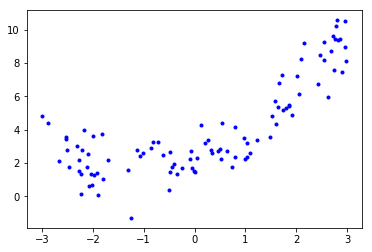

In [100]:
# Size of data set
m = 100
# Generate x values using values randomly drawn from uniform distribution between 0 and 1
X = 6 * np.random.rand(m, 1) - 3
# Quadratic function of x plus standard Gaussian noise
# y = 0.5x^2 + x + 2
y = 0.5 * (X**2) + X + 2 + np.random.randn(m,1)

plt.plot(X, y, 'b.');

In [101]:
from sklearn.preprocessing import PolynomialFeatures

quad_features = PolynomialFeatures(degree=2, include_bias=False)
X_quadratic = quad_features.fit_transform(X)
print(f'Original features: \n{X[:3]}') 
print(f'\nQuadratic feature added: \n{X_quadratic[:3]}')

Original features: 
[[-0.24520181]
 [-1.79243336]
 [ 2.71516199]]

Quadratic feature added: 
[[-0.24520181  0.06012393]
 [-1.79243336  3.21281734]
 [ 2.71516199  7.37210461]]


In [102]:
# Use linear regression to create polynomial model!
lin_reg.fit(X_quadratic, y)
# Should be close to 2, 1, and 0.5
lin_reg.intercept_, lin_reg.coef_

(array([2.16686971]), array([[1.0530075 , 0.49964914]]))

Keep in mind that PolynomialFeatures adds every combination of features up to the specified degree. For example, adding quadratic features with original features a and b will generate a^2, ab, and b^2. The number of features grows factorially, which gets to be very large quickly!

It is very possible that we pick a degree that is too high for our polynomial features and end up overfitting the data. One way to see whether we are overfitting or underfitting the data is to plot learning curves, or accuracy/error vs training set size.

In [107]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    # Create training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    # Loop through possible training set sizes
    for train_size in range(1, len(X_train)):
        # Fit on data of training set size
        model.fit(X_train[:train_size], y_train[:train_size])
        # Predictions on training and validation sets
        y_train_predict = model.predict(X_train[:train_size])
        y_val_predict = model.predict(X_val)
        # Add errors to lists
        train_errors.append(mean_squared_error(y_train_predict, y_train[:train_size]))
        val_errors.append(mean_squared_error(y_val_predict, y_val))
        
    plt.plot(np.sqrt(train_errors), 'r-', label='train')
    plt.plot(np.sqrt(val_errors), 'b-', label='validation')
    plt.legend(loc='best')

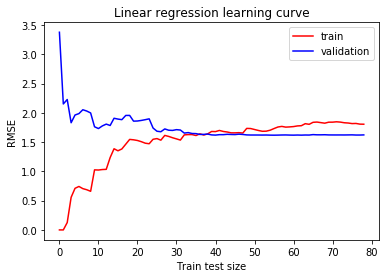

In [108]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y) 
plt.xlabel('Train test size')
plt.ylabel('RMSE')
plt.title('Linear regression learning curve');

Our model is probably underfitting the data since the error is quite high (our model is not complex enough to accurately conform to the data) and the training and validation error are close. If we were overfitting, the training error is small but our model performs poorly when evaluated on our validation set, as seen below.  

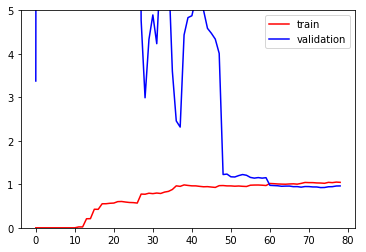

In [116]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
    ('polynomial', PolynomialFeatures(degree=10, include_bias=False)),
    ('regression', LinearRegression())
])

plot_learning_curves(polynomial_regression, X, y)
plt.ylim([0,5]);

## Regularization 

One common method for dealing with the problem of overfitting is regularization. Regularization terms are added to loss functions in order to penalize more complex models. Keep in mind that these regularization penalties will only be added to cost functions during training, because they are used to find optimal parameters, and not when we are evaluating our final model. We will be going over three types of regularization, beginning with Ride Regression. 

### Ridge Regression

In ridge regression, a regularization term which sums the square of the weights and multiplies this sum by alpha is added to the cost function. This makes sure the parameter values don't get too high, and the magnitude of alpha controls how strict this penalty is. 

In [118]:
from sklearn.linear_model import Ridge

# Generate same linear data as above
X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

# Solver selects how computation is performed
ridge_reg = Ridge(alpha=1, solver='cholesky')
ridge_reg.fit(X, y)
ridge_reg.intercept_, ridge_reg.coef_

(array([[1.17707707]]), array([3.79957451]))

In [120]:
# L2 penalty is the same penalty used in ridge regression
sgd_reg = SGDRegressor(penalty='l2')
sgd_reg.fit(X, y.ravel())
sgd_reg.intercept_, sgd_reg.coef_

/home/hussain/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


(array([2.8754271]), array([1.24511037]))

We can see in both cases the parameter values are lower than they were without the penalty term. In this case, this actually leads our model to perform worse because our data was generated by a very simple linear function, so we would not have been as prone to overfitting.

### Lasso Regression

Lasso regression is similar to ridge regression, but instead of squaring the weights, we take the absolute value. This has the effect of reducing some parameter values to 0. 

In [126]:
from sklearn.linear_model import Lasso

lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
print(lasso_reg.intercept_, lasso_reg.coef_)

sgd_reg = SGDRegressor(penalty='l1')
sgd_reg.fit(X, y.ravel())
print(sgd_reg.intercept_, sgd_reg.coef_)

[3.804446] [1.15017689]
[2.89745079] [1.25950164]


/home/hussain/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


### Elastic Net

Finally, elastic net is a regularization technique that combines both ridge and lasso regression. Both penalties are added to the cost function, but the L1 or lasso term is multiplied by the mix ratio or l1 ratio r, and the L2 or ridge term is multiplied by (1-r)/2. When r=0, elastic net is equivalent to ridge regression and r=1 corresponds to lasso regression. This hyperparameter can be be chosen using grid search. 

In [127]:
from sklearn.linear_model import ElasticNet

elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X, y)
elastic_net.intercept_, elastic_net.coef_

(array([3.80485437]), array([1.1479219]))

As a general rule, Elastic Net with a grid search over alpha is preferred over ridge and lasso techniques. Lasso and Elastic Net are also better suited to finding the most useful features because of their shrinkage properties, but Elastic Net and ridge regression will usually perform better if you have more features than data points or highly correlated variables.

## Logistic Regression

Logistic regression, despite its name, is a classification algorithm that computes a weighted sum of of the features (plus an intercept term with a value of 1) just like linear regression, but applies the sigmoid function to this sum to get an output between 0 and 1. This is interpreted as a probability (a probability greather than 0.5 would mean the instance belongs to the positive class), with the [log loss](http://wiki.fast.ai/index.php/Log_Loss) cost function. In the case of multiclass classification problems, sklearn uses an OvA strategy as mentioned in chapter 3. While there is no closed forum solution for finding the best parameters for the log loss function, it is a convex function so gradient descent is guaranteed to eventually reach the global minimum.

In [133]:
from sklearn import datasets

iris = datasets.load_iris()
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [157]:
# Petal width
X = iris['data'][:,3].reshape(-1,1)
# Positive class is virginica 
y = (iris['target'] == 2).astype(np.int)

In [158]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X, y)

/home/hussain/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

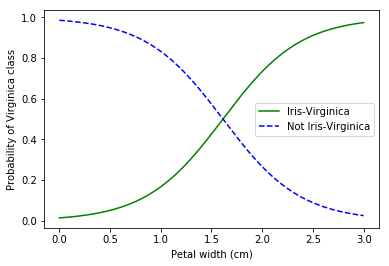

In [165]:
# Plot the predicted probabilities
X_axis = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_axis)

plt.plot(X_axis, y_proba[:, 1], "g-", label="Iris-Virginica");
plt.plot(X_axis, y_proba[:, 0], "b--", label="Not Iris-Virginica");
plt.xlabel('Petal width (cm)')
plt.ylabel('Probability of Virginica class');
plt.legend(loc='best');

In [168]:
log_reg.predict([[1.0], [2.0]])

array([0, 1])

As we stated above, if logistic regression outputs a probability greater than 0.5, it predicts our instance is in the positive class Virginica, as we demonstrate using log_reg.predict. 

## Softmax Regression

We can also create a multiclass logistic regression model by passing in a multi_class parameter. Let's use softmax regression, or multinomial logistic regression, which calculates a score again using a weighted sum of the feature vectors and then applies the softmax function to these scores to get a probability for each class. It predicts the class with the highest probability.

In [171]:
# Petal length and width data
X = iris['data'][:, (2,3)] 
# Include all 3 classes
y = iris['target']

# C is the inverse of regularization strength (higher value -> smaller penalty)
softmax_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', C=10)
softmax_reg.fit(X, y)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

[0, 7, 0, 3.5]

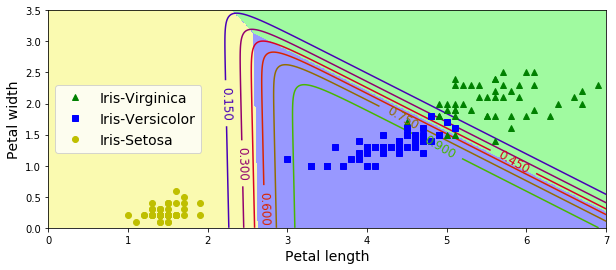

In [174]:
# Plot decision boundaries 
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]


y_proba = softmax_reg.predict_proba(X_new)
y_predict = softmax_reg.predict(X_new)

zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris-Virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris-Versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris-Setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 7, 0, 3.5]);